In [1]:
import pandas as pd
tweets = pd.read_csv("http://cssbook.net/d/covid.csv")
tweets.head()

,status_id,created_at,screen_name,lang,location,text,retweet_count,reply_to_screen_name
0,1309535775109926912,2020-09-25T16:50:33Z,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has...,1203,NaN
1,1309626010221129729,2020-09-25T22:49:07Z,GeoRebekah,en,"Florida, USA",On the day @GovRonDeSantis rejects the experts...,1146,NaN
2,1309578234007257088,2020-09-25T19:39:16Z,AlexBerenson,en,New York,Updated @cgcgov figures: 66 children under 15 ...,988,NaN
3,1309557875296083969,2020-09-25T18:18:22Z,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again ...,953,NaN
4,1309643186827132929,2020-09-25T23:57:22Z,B52Malmet,en,"New York, NY",Dr. Fauci warns the worst public health crisis...,946,NaN


<AxesSubplot:xlabel='created_at'>

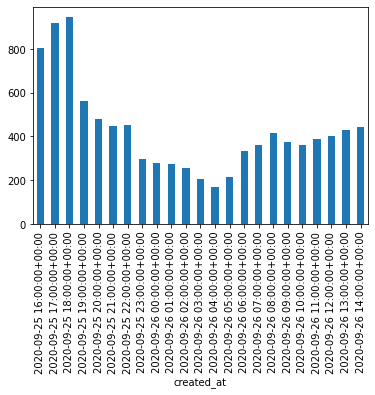

In [2]:
tweets.index = pd.DatetimeIndex(tweets['created_at'])
tweets['status_id'].groupby(pd.Grouper(freq='H')).count().plot(kind='bar')

(-0.5, 399.5, 199.5, -0.5)

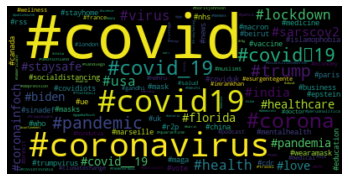

In [3]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import defaultdict
import re
mycounter = defaultdict(int)
for tweet in tweets['text']:
    for hashtag in re.findall("#\w+", tweet):
            mycounter[hashtag.lower()]+=1
mywordcloud = WordCloud().generate_from_frequencies(mycounter)
plt.imshow(mywordcloud, interpolation='bilinear')
plt.axis("off")

In [4]:
from gensim import corpora, models
from gensim import models
import re
hashtags = [[hashtag.lower() for hashtag in re.findall("#\w+", tweet)] for tweet in tweets['text']]
id2word = corpora.Dictionary(hashtags)
mycorpus = [id2word.doc2bow(doc) for doc in hashtags]
mymodel = models.LdaModel(mycorpus, id2word=id2word, num_topics=10, distributed=False, random_state=123)
mymodel.print_topics()

[(0,
  '0.030*"#coviduk" + 0.019*"#covid" + 0.010*"#lockdown2" + 0.007*"#police" + 0.006*"#crisis" + 0.005*"#dengue" + 0.004*"#portland" + 0.004*"#durango" + 0.004*"#salerno" + 0.003*"#politica"'),
 (1,
  '0.132*"#covid" + 0.016*"#salud" + 0.012*"#blm" + 0.008*"#fridayvibes" + 0.006*"#africa" + 0.006*"#safety" + 0.005*"#sugar" + 0.005*"#ethanol" + 0.005*"#francia" + 0.005*"#rbob"'),
 (2,
  '0.105*"#covid" + 0.030*"#vaccine" + 0.029*"#lockdown" + 0.014*"#quarantine" + 0.008*"#campania" + 0.007*"#sports" + 0.007*"#economy" + 0.007*"#unga" + 0.006*"#unemployment" + 0.006*"#covidtesting"'),
 (3,
  '0.151*"#covid" + 0.112*"#covid19" + 0.067*"#coronavirus" + 0.048*"#covid_19" + 0.045*"#corona" + 0.023*"#covidー19" + 0.012*"#biden" + 0.010*"#sarscov2" + 0.009*"#covid__19" + 0.007*"#coronainfoch"'),
 (4,
  '0.664*"#covid" + 0.010*"#covidー19" + 0.005*"#covidiots" + 0.005*"#masks" + 0.004*"#cdc" + 0.004*"#covid19" + 0.004*"#podcast" + 0.003*"#marseille" + 0.003*"#nhs" + 0.003*"#youtube"'),
 (5,
 

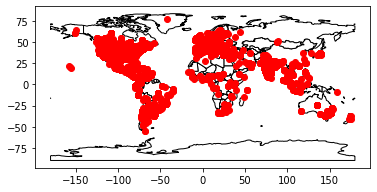

In [5]:
import geopandas as gpd
users = pd.read_csv("http://cssbook.net/d/covid_users.csv")
tweets = tweets.merge(users, on='screen_name', how='left')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = gpd.GeoDataFrame(tweets, geometry=gpd.points_from_xy(tweets.long, tweets.lat))
ax = world.plot(color='white', edgecolor='black')
gdf.plot(ax=ax, color='red')
plt.show()

/usr/local/lib/python3.8/dist-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


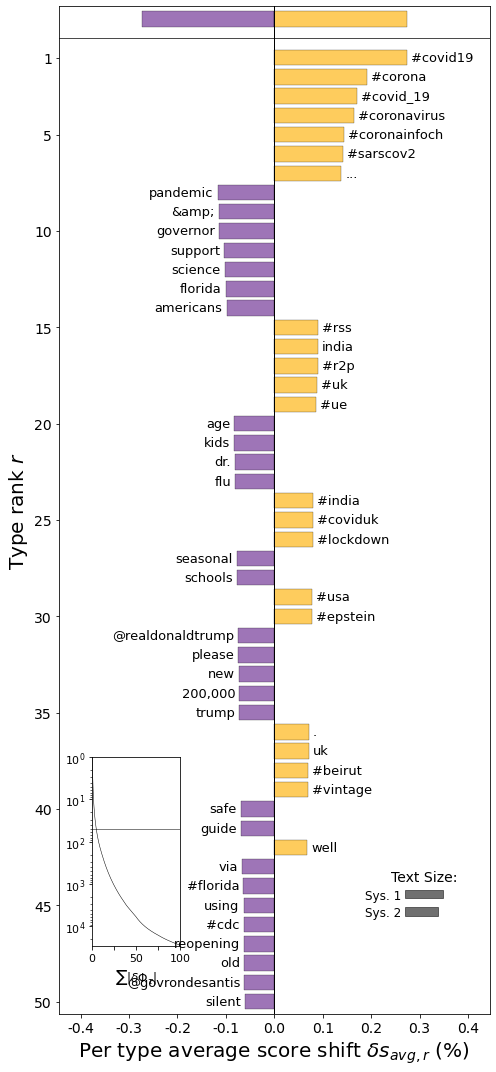

In [6]:
import shifterator as sh
from collections import Counter
from nltk.corpus import stopwords
corpus_northamerica = gdf.query("lang=='en' & (long<-60 & lat>25)")['text'].str.cat()
corpus_rest = gdf.query("lang=='en' & (long>-60 | lat<25)")['text'].str.cat()
count_northamerica = Counter(corpus_northamerica.lower().split())
count_rest = Counter(corpus_rest.lower().split())
for k in stopwords.words('english'):
    del count_northamerica[k]
    del count_rest[k]
proportion_shift = sh.ProportionShift(type2freq_1=count_northamerica,
                                      type2freq_2=count_rest)
proportion_shift.get_shift_graph()